In [78]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import statsmodels.api as sm
import statsmodels.stats.multitest as smt
from scipy import stats
import statistics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import median_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import statsmodels.formula.api as smf
import matplotlib.patches as mpatches

## Load the methylation matrix and the phenotypes

In [3]:
data = pd.read_csv('semen_data/new_semen_methylation_matrix.csv',index_col=0)

In [26]:
pheno = pd.read_csv('semen_data/semen_traits.csv',index_col=0)

In [27]:
## imputation
imputer = KNNImputer(n_neighbors=5)
pheno_imputed = pd.DataFrame(imputer.fit_transform(pheno),columns = pheno.columns)
pheno_imputed.index = pheno.index

## Figure 1 b

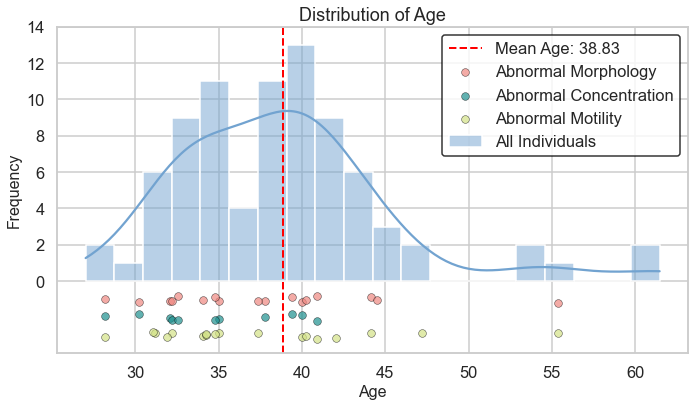

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(pheno['Age'], color='#72a3d0', kde=True, bins=20, label='All Individuals')

pheno_imputed['Morphology Status'] = pheno_imputed['Morphology'].apply(lambda x: 1 if x <4 else 0)
pheno_imputed['Concentration Status'] = pheno_imputed['Concentration'].apply(lambda x: 1 if x <15 else 0)
pheno_imputed['Motility Status'] = pheno_imputed['Motility'].apply(lambda x: 1 if x <32 else 0)

abnormal_morphology_ages = pheno_imputed[pheno_imputed['Morphology Status'] == 1]['Age']
abnormal_concentration_ages = pheno_imputed[pheno_imputed['Concentration Status'] == 1]['Age']
abnormal_motility_ages = pheno_imputed[pheno_imputed['Motility Status'] == 1]['Age']

def jitter(values, amount=0.5):
    return values + np.random.uniform(-amount, amount, size=len(values))

# Overlay ages with abnormal statuses using scatter points
plt.scatter(abnormal_morphology_ages, jitter([-1]*len(abnormal_morphology_ages), 0.2), color='#EF8881', edgecolor='black', linewidth=0.5, label='Abnormal Morphology', s=60, marker='o', alpha=0.7)
plt.scatter(abnormal_concentration_ages, jitter([-2]*len(abnormal_concentration_ages), 0.2), color='#1E908F', edgecolor='black', linewidth=0.5, label='Abnormal Concentration', s=60, marker='o', alpha=0.7)
plt.scatter(abnormal_motility_ages, jitter([-3]*len(abnormal_motility_ages), 0.2), color='#D3E287', edgecolor='black', linewidth=0.5, label='Abnormal Motility', s=60, marker='o', alpha=0.7)

# Mark the mean age with a vertical line
mean_age = pheno['Age'].mean()
plt.axvline(mean_age, color='red', linestyle='--', linewidth=2, label=f'Mean Age: {mean_age:.2f}')

# Add title, labels, and legend
plt.title('Distribution of Age', fontsize=18)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(loc='upper right', frameon=True, edgecolor='black')

# Hide the negative y-axis ticks
y_ticks = plt.gca().get_yticks()
plt.gca().set_yticks([tick for tick in y_ticks if tick >= 0])

plt.tight_layout()
plt.show()


## Figure 1 c

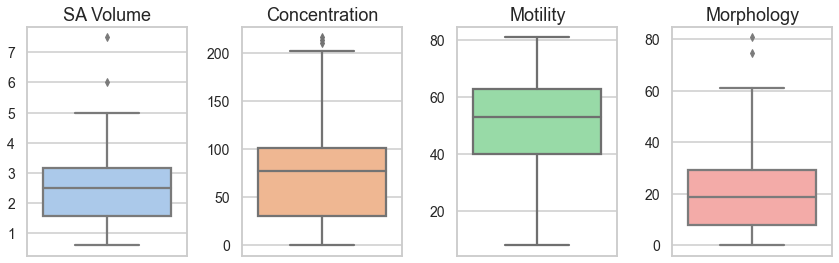

In [29]:
df = pheno[['SA Volume','Concentration','Motility','Morphology']]

sns.set_style("whitegrid")
sns.set_context("talk")

n_vars = df.shape[1]
fig, axes = plt.subplots(nrows=1, ncols=n_vars, figsize=(3 * n_vars, 4))

palette = sns.color_palette("pastel", n_vars)

for i, col in enumerate(df.columns):
    sns.boxplot(y=df[col], ax=axes[i], color=palette[i])
    axes[i].set_title(f'{col}', fontsize=18)
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='y', labelsize=14)


plt.tight_layout()
#plt.savefig('boxplot.png',dpi=300)
plt.show()


## Algorithm

In [30]:
pheno = pd.read_csv('semen_data/semen_traits.csv',index_col=0)

In [31]:
#pheno.drop('Blood_Mono',axis=1,inplace=True)
pheno.drop('Blood_Tcell',axis=1,inplace=True)
pheno.drop('Blood_Granu',axis=1,inplace=True)
pheno.drop('Concentration',axis=1,inplace=True)
pheno.drop('SA Volume',axis=1,inplace=True)
pheno.drop('Motility',axis=1,inplace=True)
pheno.drop('Morphology',axis=1,inplace=True)
pheno.rename(columns={'age':'Age'},inplace=True)
pheno.rename(columns={'Blood_Granu':'Other/Myeloid'},inplace=True)
pheno.rename(columns={'Blood_Tcell':'Lymphoid'},inplace=True)
pheno.rename(columns={'Prostate_Epi':'Epithelial'},inplace=True)

In [32]:
## standardize
scaler = MinMaxScaler()
pheno_scaled = pd.DataFrame(scaler.fit_transform(pheno), columns = pheno.columns)
pheno_scaled.columns = pheno.columns
pheno_scaled.index = pheno.index

## imputation for any NA
imputer = KNNImputer(n_neighbors=5)
pheno_imputed = pd.DataFrame(imputer.fit_transform(pheno_scaled),columns = pheno_scaled.columns)
pheno_imputed.index = pheno_scaled.index

In [35]:
## Add batch term and constant term
sheet = pd.read_excel('Sample_Sheet_Infertility_2 (1).xlsx')
sheet = sheet.iloc[0:80,:]
sheet['Sample_ID (study number)'] = sheet['Sample_ID (study number)'].str.replace(r'-', '_', regex=True)
record = []
for i in sheet['Sample_ID (study number)']:
    record.append(i[0:5])

batch = []
for i in pheno_imputed.index:
    if i[0:5] in record:
        batch.append(2)
    else:
        batch.append(1)
        
pheno_imputed['batch'] = batch
pheno_imputed['constant'] = 1

In [36]:
## perform pseudo-inverse
Ypred=[]
keeper = []

for i in tqdm(data.index):
    if i[0:5] in keeper:
        continue
    else:
        keeper.append(i[0:5])
    Xtrain = np.array(data[data.index.str.contains(i[0:5]) == False])
    Xtest = np.array(data[data.index.str.contains(i[0:5]) == True])
    
    Ytrain = np.array(pheno_imputed[pheno_imputed.index.str.contains(i[0:5]) == False])
    
    C = np.dot(np.linalg.pinv(Ytrain),Xtrain)
    Ypred.append(np.dot(Xtest,np.linalg.pinv(C)))

100%|██████████| 82/82 [00:05<00:00, 15.60it/s]


In [41]:
# prediction
Ypred = np.row_stack(Ypred)

# coefficients
C = pd.DataFrame(C)
C.index = pheno_imputed.columns
C.columns = data.columns

In [42]:
# predicted methylation
Xpred = np.dot(Ypred,C)
Xpred = np.row_stack(Xpred)
Xpred = pd.DataFrame(Xpred)
Xpred.index = data.index
Xpred.columns = data.columns

In [45]:
# drop these coefficients for plotting
C.drop('constant',axis=0,inplace=True)
C.drop('batch',axis=0,inplace=True)

## Compute the p-values

In [46]:
pheno_imputed.drop('constant',axis=1,inplace=True)

X = pd.DataFrame(pheno_imputed)
Y = pd.DataFrame(data)

# Add a constant column to X for the intercept
X = sm.add_constant(X)

# Loop over each response variable in Y
p_values = []
for i in tqdm(range(Y.shape[1])):
    # Fit a univariate linear regression model for the i-th response variable
    model = sm.OLS(Y.iloc[:, i], X)
    results = model.fit()

    # Get the p-value for the i-th predictor variable
    p_values.append(results.pvalues)


100%|██████████| 72000/72000 [00:39<00:00, 1835.20it/s]


In [47]:
pval_res = pd.DataFrame(p_values)
pval_res.index = data.columns

In [48]:
# multiple-testing for all the p-values
result = pd.DataFrame()
for i in pval_res.columns:
    p = pd.DataFrame(smt.multipletests(pval_res[i], method='fdr_bh')[1])
    result = pd.concat([result,p],axis=1)
result.index = pval_res.index
result.columns = pval_res.columns

In [50]:
result.sort_values(by='Sperm',inplace=True)

## Correlation between predicted and true methylation sites (first filter)

In [52]:
correlation = []
for i in tqdm(range(len(data.columns))):
    R = np.corrcoef(Xpred.iloc[:,i],data.iloc[:,i])[0][1]
    correlation.append(R)

100%|██████████| 72000/72000 [00:08<00:00, 8619.52it/s]


In [53]:
correlation = pd.DataFrame({'R': correlation})
correlation.index = data.columns

In [54]:
correlation = correlation[abs(correlation['R'])>=0.5]

In [55]:
## select the sites with correlation greater than or equal to 0.5
C = C.loc[:,correlation.index]

## Figure 3

In [75]:
Ypred = pd.DataFrame(Ypred)
Ypred.index = pheno_imputed.index
Ypred.columns = pheno_imputed.columns

In [77]:
Ypred.drop('batch',axis=1,inplace=True)
Ypred.drop('constant',axis=1,inplace=True)

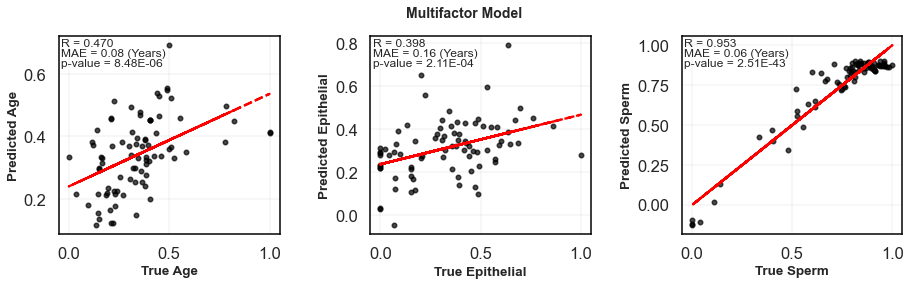

In [79]:
plt.rcParams.update({'font.size': 10})

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 4))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

    ax.scatter(pheno_imputed.iloc[:, i], Ypred.iloc[:, i], c='black', s=20, alpha=0.7)
    
    # Calculate correlation coefficient and p-value
    corr_coef, p_value = stats.pearsonr(pheno_imputed.iloc[:, i], Ypred.iloc[:, i])
    mae = median_absolute_error(pheno_imputed.iloc[:, i],Ypred.iloc[:, i])
    
    ax.set_xlabel('True '+ Ypred.columns[i], fontsize=13.5,fontweight='bold')
    ax.set_ylabel('Predicted '+ Ypred.columns[i], fontsize=13.5,fontweight='bold')
    
    # Add regression line
    z = np.polyfit(pheno_imputed.iloc[:, i], Ypred.iloc[:, i], 1)
    p = np.poly1d(z)
    ax.plot(pheno_imputed.iloc[:, i], p(pheno_imputed.iloc[:, i]), color='red', linestyle='--', label='Regression line')
    
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)  
        spine.set_color('black')
    
    # Add correlation coefficient and MAE to the plot
    ax.text(0.01, .95, f'R = {corr_coef:0.3f}', transform=ax.transAxes, fontsize=12)
    ax.text(0.01, .90, f'MAE = {mae:0.2f} (Years)', transform=ax.transAxes, fontsize=12)
    ax.text(0.01, .85, f'p-value = {p_value:0.2E}', transform=ax.transAxes, fontsize=12)
    
fig.suptitle('Multifactor Model', fontsize=14,fontweight='bold')
fig.subplots_adjust(hspace=2, wspace=2.7)
plt.tight_layout()
#plt.savefig("multifactor_model.pdf", format="pdf", bbox_inches="tight")
#plt.savefig('multifactor_model.png', dpi=300)
plt.show()

## Select sites

In [81]:
semen_pval = result
semen_pval.drop('const',axis=1,inplace=True)
semen_pval.drop('batch',axis=1,inplace=True)

In [83]:
# pvalues less than 0.05, correlation >=0.5
semen_sig = semen_pval[semen_pval['Sperm']<=0.05]
index = list(set(semen_sig.index.to_list()) & set(C.columns))

In [84]:
overlap = C.loc[:,index]

In [94]:
overlap.head()

,chr6:168035699,chr14:24070965,chr6:33432179,chr7:73434174,chr22:10741727,chr14:74355481,chr10:89328047,chr19:6739223,chr1:154503142,chr6:149454717,...,chr13:27447637,chr1:28736330,chr4:186889511,chr17:21452950,chr17:32523468,chr16:15143915,chr12:112937986,chr2:219572135,chr6:31572393,chr22:36706070
Age,-0.077598,0.009064,-0.064254,-0.020824,-0.008523,0.020319,-0.075689,-0.027296,0.002659,0.041239,...,-0.103266,-0.016650,-0.089962,-0.041073,0.010215,0.010780,-0.023507,-0.064551,-0.000297,0.008942
Epithelial,-0.039065,-0.010531,0.057446,0.003095,0.035506,0.026849,-0.061167,-0.012648,0.010480,-0.020643,...,0.039217,0.013355,0.058981,-0.034624,0.007887,0.028858,0.007436,0.005055,0.004744,-0.001242
Sperm,-0.513024,0.709036,0.634742,-0.154228,-0.620648,0.059591,0.294356,-0.089400,-0.197115,0.786092,...,-0.132696,-0.129637,-0.908619,-0.604941,0.080502,0.172222,-0.191492,-0.486659,0.080893,0.305915


In [87]:
# largest among other features
record = []
for i in overlap.columns:
    temp = list(abs(overlap.loc[:,i]))
    max_index = temp.index(max(temp))
    if max_index == 2: ## adjusting the index to 0 and 1 will correspond to Age and Epithelial cell
        record.append(i)    

In [88]:
res = semen_pval.loc[semen_pval.index.isin(record)].copy()
res.sort_values(by='Sperm',inplace=True)

In [89]:
## choose the top 200 sites
sperm_res = res.iloc[0:200,:].copy()
res = data.loc[:,sperm_res.index].copy()
res['Sperm'] = pheno['Sperm']

In [91]:
# distinguish the positive and negative sites
# it's the same result if we just take the sign of the coefficients
positive = []
negative = []
for i in res.columns:
    corr, p_value = stats.pearsonr(res['Sperm'], res[i])
    if corr > 0:
        positive.append(i)
    elif corr < 0:
        negative.append(i)
positive = positive[:-1]

In [92]:
len(positive)

48

In [93]:
len(negative)

152